# Examples of Plotting with `pyseas`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mpcolors
import skimage.io
import pandas as pd
import cartopy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import pyseas
from pyseas import maps, styles
from pyseas.contrib import plot_tracks

%matplotlib inline

## Recomended Style

Import maps and styles directly. For other modules, reference
through the pyseas namespace.

     import pyseas
     from pyseas import maps, styles

## Basic Mapping

Projections can be specified by using any of the names found in the acompanying 
`projection_info.md` document, or with any Cartopy projection. There are built in 
light and dark styles, which are activated using `pyseas.context`.

In [ ]:
with pyseas.context(styles.dark):
    fig = plt.figure(figsize=(18, 6))
    maps.create_map(projection='regional.european_union')
    maps.add_land()

In addition to `add_land` there a number of other features that can be added to maps
including eezs, grid_lines, countries, logos, etc.

In [ ]:
with pyseas.context(styles.light):
    fig = plt.figure(figsize=(18, 6))
    maps.create_map(projection='country.china')
    maps.add_land()
    maps.add_countries()
    maps.add_eezs()
    maps.add_gridlines()
    maps.add_gridlabels()
    maps.add_logo(loc='upper left')

If not region is specified, you get the default global map as specified by the 
projection name `global.default`. Currently that's ExactEarth centered at 0 longitude.

In [ ]:
with pyseas.context(styles.light):
    fig = plt.figure(figsize=(18, 6))
    maps.create_map()
    maps.add_land()
    maps.add_countries()
    maps.add_eezs()
    maps.add_gridlines()
    # Note gridlabels don't currently work on global maps

## Rasters

There are facilities for creating and displaying rasters.

In [2]:
# Grab some data and create a raster
query = """
with seismic as 
(select distinct ssvid from (
select ssvid, v  from `gfw_research.vi_ssvid_v20200312` cross join
unnest(registry_info.best_known_vessel_class) v
 ) where v = 'seismic_vessel'
 ),
 good_segs as (select seg_id from `gfw_research.pipe_v20190502_segs`  where 
 good_seg and not overlapping_and_short
 and positions > 20)
 select 
 floor(lat*10) lat_bin,
 floor(lon*10) lon_bin,
 sum(hours) hours,
 sum(if(nnet_score>.5,1,0)) fishing_hours
 from `gfw_research.pipe_v20190502` 
 join seismic
 using(ssvid)
 where date between timestamp("2019-01-01") and timestamp("2019-12-31")
 and seg_id in (select seg_id from good_segs)
 group by lat_bin, lon_bin
 """
seismic_presence = pd.read_gbq(query, project_id='world-fishing-827', dialect='standard') 
seismic_raster = maps.rasters.df2raster(seismic_presence, 'lon_bin', 'lat_bin', 'hours', 
                                         xyscale=10, origin='lower', per_km2=True)

/Users/jennifervanosdel/miniconda3/envs/gfw-viz/lib/python3.8/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_schema is deprecated as of 0.17.0, please use pyarrow.ipc.read_schema instead
  warnings.warn(msg, FutureWarning)
/Users/jennifervanosdel/miniconda3/envs/gfw-viz/lib/python3.8/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.read_record_batch is deprecated as of 0.17.0, please use pyarrow.ipc.read_record_batch instead
  warnings.warn(msg, FutureWarning)


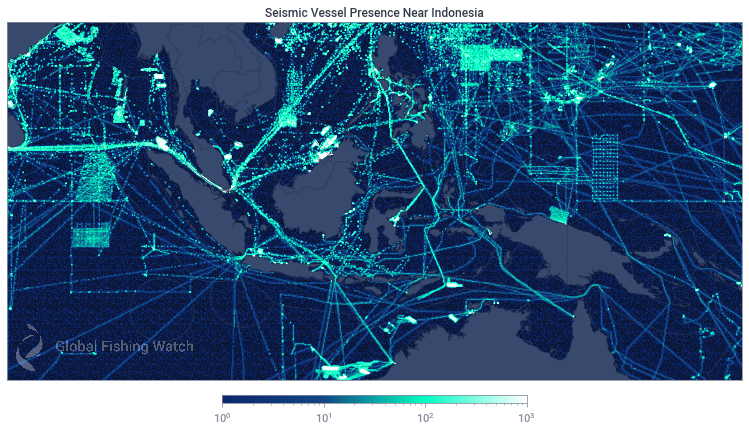

In [4]:
# Display a raster along with standard colorbar.
fig = plt.figure(figsize=(14, 7))
norm = mpcolors.LogNorm(vmin=1, vmax=1000)
with plt.rc_context(styles.dark):
    ax, im = maps.plot_raster(seismic_raster * (60 * 60), 
                              projection='country.indonesia',
                              cmap='presence',
                              norm=norm,
                              origin='lower')
    maps.add_countries()
    maps.add_eezs()
    ax.set_title('Seismic Vessel Presence Near Indonesia')
    fig.colorbar(im, ax=ax, 
                      orientation='horizontal',
                      fraction=0.02,
                      aspect=40,
                      pad=0.04,
                     )
    maps.add_logo(loc='lower left')

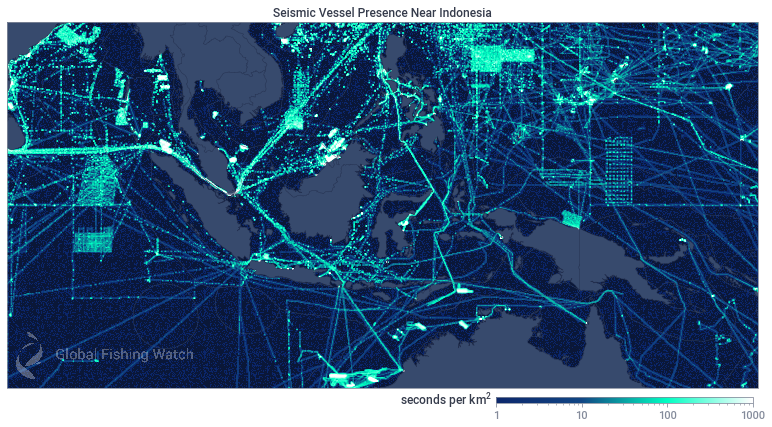

In [5]:
# Display a raster along with aligned, labeled colorbar.
fig = plt.figure(figsize=(14, 7))
norm = mpcolors.LogNorm(vmin=1, vmax=1000)
with plt.rc_context(styles.dark):
    ax, im, cb = maps.plot_raster_w_colorbar(seismic_raster * (60 * 60), 
                                             r"seconds per $\mathregular{km^2}$ ",
                                             projection='country.indonesia',
                                             cmap='presence',
                                             norm=norm,
                                             cbformat='%.0f',
                                             origin='lower',
                                             loc='bottom')
    maps.add_countries()
    maps.add_eezs()
    ax.set_title('Seismic Vessel Presence Near Indonesia')
    maps.add_logo(loc='lower left')

It's important to realize that normally one is not seeing the background of the map over water, 
but instead the zero value of the raster. Sometimes it's useful to make some portion of the 
raster transparent, which can be done by setting values to np.nan. A somewhat contrived example
is shown below, where normally using a light colormap with a dark background would result in
a bizzare light background, but this is prevented by making the background transparent.

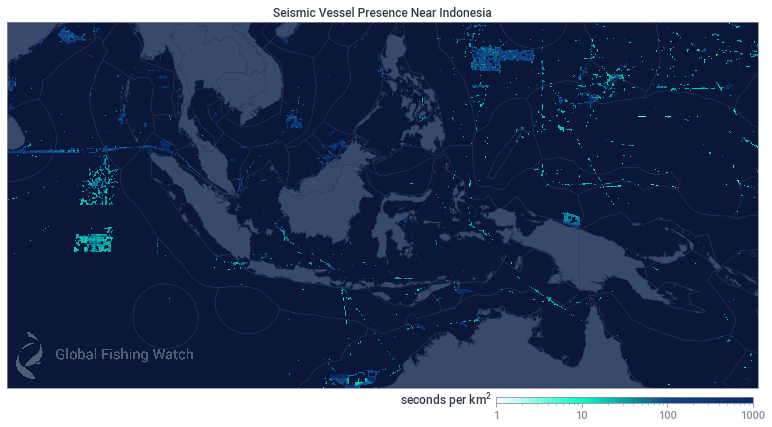

In [3]:
fig = plt.figure(figsize=(14, 7))
norm = mpcolors.LogNorm(vmin=1, vmax=1000)
raster = seismic_raster.copy()
raster[raster == 0] = np.nan
with plt.rc_context(styles.dark):
    ax, im, cb = maps.plot_raster_w_colorbar(raster * (60 * 60), 
                                             r"seconds per $\mathregular{km^2}$ ",
                                             projection='country.indonesia',
                                             cmap=pyseas.cm.light.presence,
                                             norm=norm,
                                             cbformat='%.0f',
                                             origin='lower',
                                             loc='bottom')
    maps.add_countries()
    maps.add_eezs()
    ax.set_title('Seismic Vessel Presence Near Indonesia')
    maps.add_logo(loc='lower left')

## Plotting Tracks

There are two base functions for plotting vessel tracks. `maps.plot` is
a simple wrapper around `plt.plot` that plots tracks specified in lat/lon,
but is otherwise identical `plt.plot`. The alternative, `maps.add_plot` can plot plot tracks
with multiple subsegments, using different styles for each subsegment.

Both of these support creation of legends. However, the second requires a bit
of manual intervention.

In [ ]:
query = """
    select ssvid, lat, lon, timestamp, seg_id, speed
    from `world-fishing-827.pipe_production_v20200203.messages_scored_2018*`
    where _TABLE_SUFFIX between "0101" and "0131"
    and ssvid in ("413461490", "249014000", "220413000")
    and seg_id is not null
    order by timestamp
    """
position_msgs = pd.read_gbq(query, project_id='world-fishing-827', dialect='standard')  

Note the use of `maps.find_projection` to find an appropriate projection and extents
based on lat/lon data.

In [ ]:
# Simple track plotting analogous to plt.plot
with pyseas.context(pyseas.styles.light):
    fig = plt.figure(figsize=(8, 8))
    df = position_msgs[position_msgs.seg_id == '249014000-2018-01-21T16:36:23.000000Z']
    projinfo = plot_tracks.find_projection(df.lon, df.lat)
    maps.create_map(projection=projinfo.projection)
    maps.add_land()

    maps.plot(df.lon.values, df.lat.values, label='first')
    maps.plot(df.lon.values, df.lat.values + 0.1, label='second')
    maps.plot(df.lon.values - 0.3, df.lat.values, color='purple', linewidth=3, label='third')
    
    plt.legend()

One can use `add_plot` to display multiple plots at once or to display a single
plot with multiple states. In the first case one uses `break_on_change=False` and
in the second `break_on_change=True`. In either case, the value of the `props`
argument controls the color of plotted line segments. `break_on_change` controls 
how whether lines with a given `props` values are broken when the value changes.

In [ ]:
# Use add plot, to display multiple tracks at once.
with pyseas.context(pyseas.styles.light):
    fig = plt.figure(figsize=(8, 8))
    df = position_msgs[position_msgs.ssvid != '220413000']
    projinfo = maps.find_projection(df.lon, df.lat)
    maps.create_map(projection=projinfo.projection, extent=projinfo.extent)
    maps.add_land()
    handles = maps.add_plot(df.lon.values, df.lat.values, df.ssvid, break_on_change=False)
    plt.legend(handles.values(), handles.keys())

In [ ]:
# Use add plot, to display tracks with multiple values
# this simple example leaves gaps between the segments
# Generating an appropriate set of props is a bit tricky --
# here we use the built in fishing props.
with pyseas.context(pyseas.styles.light):
    fig = plt.figure(figsize=(8, 8))
    df = position_msgs[position_msgs.ssvid == '413461490']
    projinfo = plot_tracks.find_projection(df.lon, df.lat)
    maps.create_map(projection=projinfo.projection, extent=projinfo.extent)
    maps.add_land()
    handles = maps.add_plot(df.lon.values, df.lat.values, df.speed > 7, break_on_change=True,
                            props=styles._fishing_props)
    plt.legend(handles.values(), ['speed <= 7 knots', 'speed > 7 knots'])

## Panels

There are a couple of convenience functions that package up add_plot
for a couple of common cases. These also support adding subsidiary 
time/other-parameter plots and both functions will automatically choses
and appropriate projection and extents based on the input data
using `maps.find_projection`.

The first of these `multi_track_panel` is specialized for plotting multiple
tracks at once.

In [ ]:

pyseas._reload()
df = position_msgs[(position_msgs.ssvid == "413461490")]
with pyseas.context(styles.panel):
    fig = plt.figure(figsize=(12, 12))
    info = plot_tracks.multi_track_panel(df.timestamp, df.lon, df.lat, df.seg_id,
                plots=[{'label' : 'lon', 'values' : df.lon},
                       {'label' : 'lat', 'values' : df.lat}])
    plt.legend(info.legend_handles.values(), [x.split('-', 1)[1].rstrip('.000000000Z') 
                                              for x in info.legend_handles.keys()])

The second panel type, `track_state_panel`, plots single tracks with multiple states. For instance,
fishing/non-fishing, loitering/non-loitering, etc.

In [ ]:
df = position_msgs[(position_msgs.ssvid == "413461490")].reset_index()
with pyseas.context(styles.panel):
    fig = plt.figure(figsize=(12, 12))
    info = plot_tracks.track_state_panel(df.timestamp, df.lon, df.lat, df.speed > 7.0,
                    plots = [{'label' : 'speed (knots)', 'values' : df.speed, 'min_y' : 0}])

Both panel types have a number of options including `annotations` and
`add_night_shades`.

In [ ]:
pyseas._reload()
df = position_msgs[(position_msgs.ssvid == "413461490")].reset_index()
with pyseas.context(styles.panel):
    fig = plt.figure(figsize=(12, 12))
    info = plot_tracks.track_state_panel(df.timestamp, df.lon, df.lat, df.speed > 7.0,
                                        annotations=5, add_night_shades=True,
                    plots = [{'label' : 'speed (knots)', 'values' : df.speed, 'min_y' : 0}])

## Miniglobe

The miniglobe gets its own section by virtue of being one of the most complex
pieces internally, despite its relative outward simplicity. The miniglobe can
be specified to either have an AOI indicated or a marker at the specified location.

In [ ]:
with pyseas.context(styles.dark):
    fig = plt.figure(figsize=(10, 10))
    ax = maps.create_map(projection='country.indonesia')
    maps.add_land(ax)
    maps.add_countries(ax)
    maps.add_miniglobe(loc='upper left')
    plt.show()

In [ ]:
with pyseas.context(styles.dark):
    fig = plt.figure(figsize=(10, 10))
    ax = maps.create_map(projection='country.indonesia')
    maps.add_land(ax)
    maps.add_countries(ax)
    maps.add_miniglobe(loc='lower right', central_marker='*')
    plt.show()

## Plotting Gaps

See [PlotGap.ipynb](https://github.com/GlobalFishingWatch/pyseas/blob/gaps-viz/pyseas/contrib/plot_gap.py)

(or if navigating from within a clone of the repo, go directly to the file [here](contrib/PlotGap.ipynb))

## Saving Plots

Plots can be saved in the normal way, using `plt.savefig`. If a background
is needed, the standard facecolor can be applied as shown below.

In [ ]:
# plt.savefig('/path/to/file.png', dpi=300, facecolor=plt.rcParams['pyseas.fig.background'])

## Publish

In [ ]:
# import rendered
# rendered.publish_to_github('./Examples.ipynb', 
#                            'pyseas/doc', action='push')